In [1]:
import sys
import os
import numpy as np
import torch
from torch import device, nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import mkdir
import torch.optim as optim
import scipy
import matplotlib
import plotly.express as px
import pandas as pdfr
from sklearn.metrics import f1_score
import gc
import sklearn
import pandas as pd





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specify directory of folder 'IHDA'

In [ ]:
dir_IHDA               = '/content/drive/MyDrive/IHDA/'
dir_required_functions = dir_IHDA + 'Required_Functions/'

import sys
sys.path.append(dir_required_functions)
sys.path.append(dir_required_functions + 'VAE')
sys.path.append(dir_required_functions + 'FC')
sys.path.append(dir_required_functions+'Potential')
sys.path.append(dir_required_functions+'Load_Process_Data')

If you run on google colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In this notebook the first step of the IHDA algorithm is analyzed. Therefore first a VAE is trained. The following properties should be achieved during the training algorithm. 

1. Good reconstruction error
2. Reconstructed signal should represent original signal well.
3. Good latent space reperesentation.


In [2]:
import VAE
import basic_functions
import load_process_data as lpd
import train_VAE
import losses
import eval_VAE
import FC
import eval_FC
import potential
import eval_potential
import retrain_FC

#**Load training, validation and testing data:**

Short definition of those three datasets: 

*   **Training Dataset:** The sample of data used to fit the model.
*  **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
*   **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.



In [3]:
dir_fc_base   = dir_IHDA + 'BaselineClassifier/Classifier/'
dir_data_pp   = dir_fc_base + 'Data/'

#x_train , y_train, x_test, y_test = lpd.load_and_normalize_data(dir_data)

For speeding up the code simply load normalized data and do not precompute it.

Load data:

In [4]:
x_train          = torch.load(dir_data_pp + 'x_train.pth')
y_train          = torch.load(dir_data_pp + 'y_train.pth')
x_train_upsample = torch.load(dir_data_pp + 'x_train_upsample.pth')
y_train_upsample = torch.load(dir_data_pp + 'y_train_upsample.pth')

x_validate = torch.load(dir_data_pp + 'x_validate.pth')
y_validate = torch.load(dir_data_pp + 'y_validate.pth')
x_validate_upsample = torch.load(dir_data_pp + 'x_validate_upsample.pth')
y_validate_upsample = torch.load(dir_data_pp + 'y_validate_upsample.pth')

x_test = torch.load(dir_data_pp + 'x_test.pth')
y_test = torch.load(dir_data_pp + 'y_test.pth')


Decide whether classifier VAE should be trained on balanced dataset:

In [5]:
upsample_state = 1
if upsample_state == 1:
  x_train = x_train_upsample
  y_train = y_train_upsample

  x_validate = x_validate_upsample
  y_validate = y_validate_upsample

#**Evaluate baseline classifier:**

Define hyperparameters of classifier:

In [6]:
dir_fc_base_best   = dir_fc_base + 'best_model.pth' 
device             = 'cuda' # Device where calculations are performed

Initialize base classifier:

In [7]:
# Load and initialize trained VAE:
fc_base  = FC.FC(dropout_fc = 0).to(device)
fc_base  = basic_functions.initialize_model(fc_base,dir_fc_base_best)
fc_base.eval()

FC(
  (batch1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=753, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=8, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

Confusion matrix:

In [8]:
y_pred = eval_FC.classifier_predict(fc_base, x_test, device)
conf_matrix = eval_FC.calc_confusion_matrix(y_pred,y_test)
conf_matrix.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
Still,10493,157,0,97,210,234,165,220
Walking,263,8197,14,79,1,28,2,143
Run,3,44,3976,32,1,0,0,1
Bike,104,499,125,5292,27,82,3,16
Car,607,7,1,45,9457,4677,214,313
Bus,416,166,1,167,1277,8162,243,346
Train,631,103,0,63,225,484,3669,2603
Subway,266,25,1,9,31,41,844,2773


#**Train VAE:**

**Load and initialize VAE:**

Specify hyperparameters:

In [80]:
latent_dims        = 8      # Latent dimension
device             = 'cuda' # Device where calculations are performed
dropout_ratio_1    = 0.25   # Dropout ratio

Initialize VAE_1:

In [96]:
VAE_1 = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1)
VAE_1 = VAE.initialize_VAE_1(VAE_1, dir_fc_base_best)

Specify Hyperparameter:

In [137]:
batch_size  = 1000    # batch size
epochs      = 80      # number of epochs
layer       = 1       # layer to optimize
beta        = 0.025   # 0.005 beta of VAE # 0.02 # between 0.1 and 0.01
lr          = 0.0001  # Learning rate of VAE 

train_VAE_1_state = 0      # 0 not train VAE, train_VAE_state := 1 train VAE
device            = 'cuda'  # device on which the training is performed

Specify optimizer:

In [138]:
# Initialize optimizer:
optimizer  = optim.Adam(VAE_1.parameters(), lr = lr, betas=(0.9, 0.999))   #lr = 0.0000001 (normalized works and ) lr =  0.0000003, betas=(0.9, 0.999)

Create dataloaders:

In [139]:
trainloader = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = True)
validationloader = lpd.generate_dataloader(x_validate, y_validate, batch_size, shuffle = True)
testloader  = lpd.generate_dataloader(x_test, y_test, batch_size, shuffle = True)

Start training procedure:

In [140]:
def main(VAE_1,beta,latent_dims,epochs,layer,lr,trainloader,validationloader):
  # Create directory to store model:
  dir_store_folder          = train_VAE.create_directory_VAE(beta, latent_dims, epochs,layer )
  
  # Initialize optimizer:
  optimizer  = torch.optim.Adam(VAE_1.parameters(), lr = lr, betas=(0.9, 0.999))

  # Push model to device:
  VAE_1.to(device)

  # Start training procedure:
  history, VAE_1, optimizer = train_VAE.train_test(beta,VAE_1,dir_store_folder, optimizer,trainloader,validationloader,epochs,device)
  
  # Store final model:
  basic_functions.store_model(dir_store_folder, VAE_1,epochs, optimizer, model_name = 'final_model.pth')
  
  # Plot seperate losses:
  losses.plot_losses_seperatly(history) 
  print('Done with training')
  return history

if train_VAE_1_state == 1:
  history = main(VAE_1,beta,latent_dims,epochs,layer,lr,trainloader,validationloader)

**Load trained VAE:**

Load trained VAE with best test error:

In [141]:
# directory of trained model
dir_VAE_1 = '/content/drive/MyDrive/Colab_Notebooks/Experiments/Results/IHDA/FC_'+str(layer)+'/VAE/VAE_beta_'+str(beta) + '_latent_dims_' + str(latent_dims) + '_epochs_' + str(epochs) +'/' + 'best_model.pth'
  
# Load and initialize trained VAE:
VAE_1  = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1).to(device)
VAE_1  = basic_functions.initialize_model(VAE_1,dir_VAE_1)
VAE_1.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (batch1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=753, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=8, bias=True)
    (fc5): Linear(in_features=500, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=753, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

#**Evaluate quality of reconstructed signal:**

**Plot orginal versus reconstructed signal of one test sample:**

The test samples where not used during the training process.

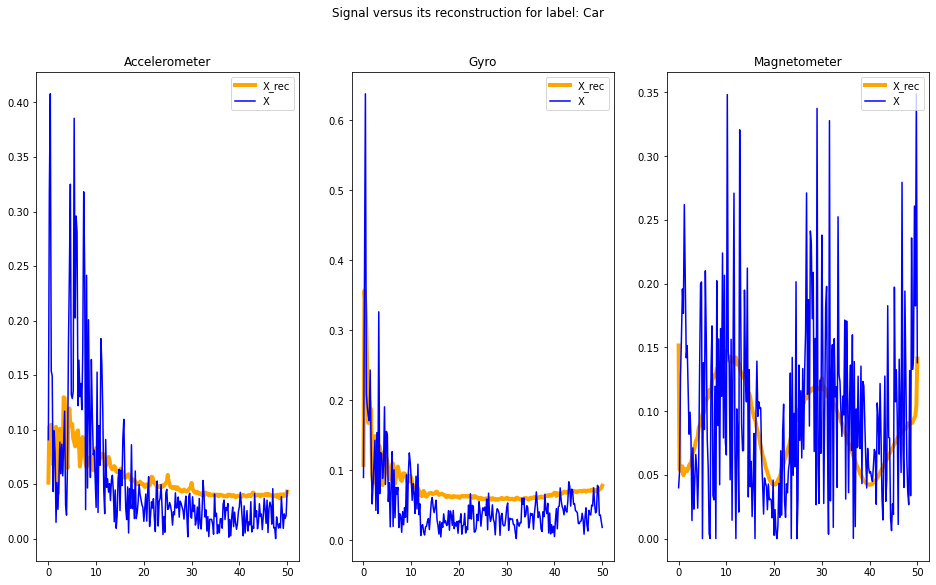

In [142]:
idx_sample = np.random.randint(0,len(x_test),1)
x_sample   = x_test[idx_sample].view(753)
y_sample   = y_test[idx_sample].detach().cpu().numpy()
x_rec      = VAE_1(x_sample.to(device)).detach().cpu().numpy()
x_rec      = np.reshape(x_rec,753)
x_sample   = x_sample.detach().cpu().numpy()

eval_VAE.plot_x_rec_vs_x(x_rec,x_sample,y_sample)

**Evaluate classification performance of reconstructed signals on baseline classifier**

Here, the original dataset x_test will be fed trhough the VAE to generate their reconstrcutions. Than the performance of the reconstructed dataset on the baseline classifier is calculated. The smaller the performance difference between reconstructed and original dataset the better the reconstructed signal resembels the original dataset.

Generate reconstructed dataset:

In [143]:
x_test_rec = VAE_1(x_test.to(device)).detach().cpu()
test_rec_loader = lpd.generate_dataloader(x_test_rec,y_test, batch_size, shuffle = True)

In [144]:
del x_test_rec
torch.cuda.empty_cache()

Initialize baseline classifier:

In [145]:
dropout_fc = 0
fc_base    = FC.FC(dropout_fc)
fc_base    = basic_functions.initialize_model(fc_base,dir_fc_base_best)

Print performance statistics on testset:

In [146]:
criterion  = nn.CrossEntropyLoss()
test_loss_ref, test_acc_ref, test_f1_ref = eval_FC.test_classifier(testloader, fc_base, device,criterion)
print('------------------------------- Baseline classifier performance on original dataset: --------------------------------')
print("test_loss: {:.4f}, test_acc: {:.4f}, test_f1:{:.4f}".format(test_loss_ref, test_acc_ref,test_f1_ref))

------------------------------- Baseline classifier performance on original dataset: --------------------------------
test_loss: 1.5113, test_acc: 0.7609, test_f1:0.7606


Print performance statistics on reconstructed trainset:

In [147]:
criterion  = nn.CrossEntropyLoss()
test_loss, test_acc, test_f1 = eval_FC.test_classifier(test_rec_loader, fc_base, device,criterion)
print('-------------------------------Baseline classifier performance on reconstructed signal: --------------------------------')
print("test_loss: {:.4f}, test_acc: {:.4f}, test_f1:{:.4f}".format(test_loss, test_acc,test_f1))

-------------------------------Baseline classifier performance on reconstructed signal: --------------------------------
test_loss: 1.6161, test_acc: 0.6536, test_f1:0.6279


#**Evaluate latent space of VAE:**

**Check for posterior collapse:**

Check for which latent variables you are expecting to face posterior collpase. 

For every latent variable n datasamples are mapped through the encoder of the VAE. Every datasample is mapped to a gaussian distribution specified by a mean mu and varaiance var. If a certain percentage of the of the variance is mapped close to a standard deviation of 1 posterior collapse can be expected.

In [135]:
n          = 50000
idx_sample = np.random.randint(0,len(x_test),n) 
x_sample   = x_test[idx_sample]
eval_VAE.calc_risk_pc(VAE_1, x_sample, latent_dims,device)

Potentially you are not facing posterior collapse for the following latent dimensions:
[0, 1, 2, 3, 4, 5, 6, 7]
The belonging risks for posterior collapse are: 
[0.00156, 0.33506, 0.553, 0.0545, 0.39922, 0.0, 0.0, 0.2927]
------------------------------------------------------------------------------------------------
Potentially you are facing posterior collapse for the following latent dimensions:
[]
The belonging risks for posterior collapse are: 
[]


**Plot latent space:**

Plot latent space, and histogram of mean and variance.

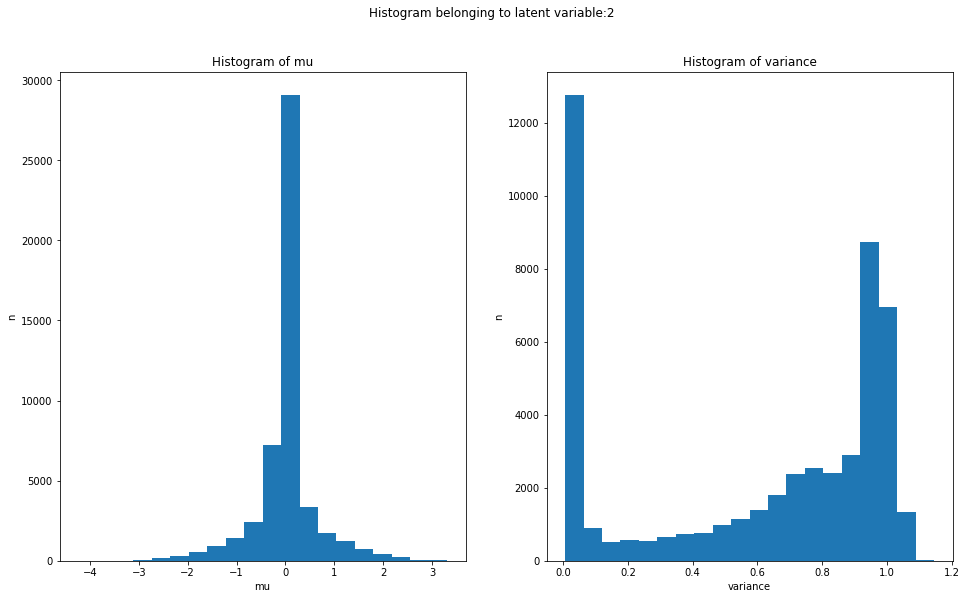

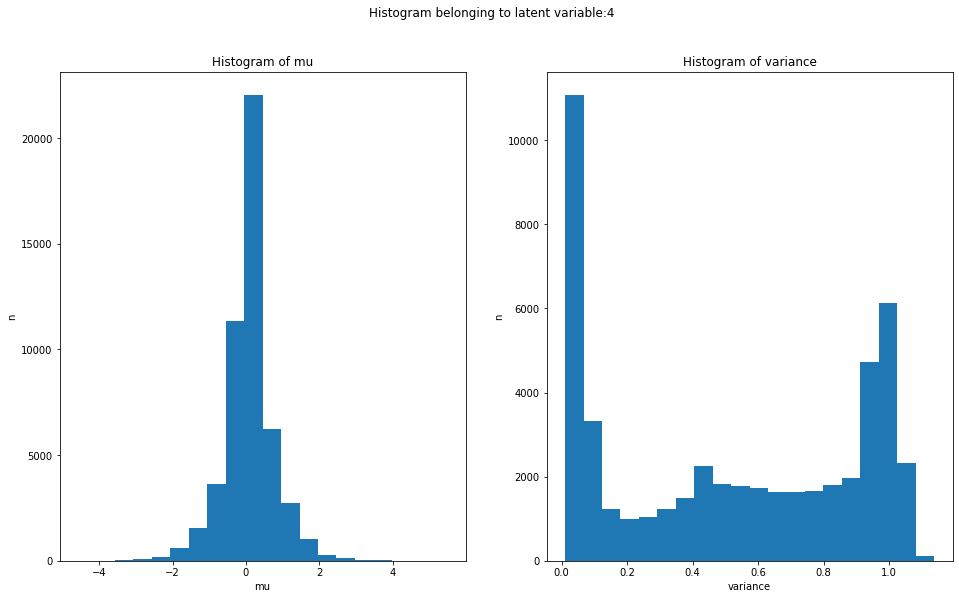

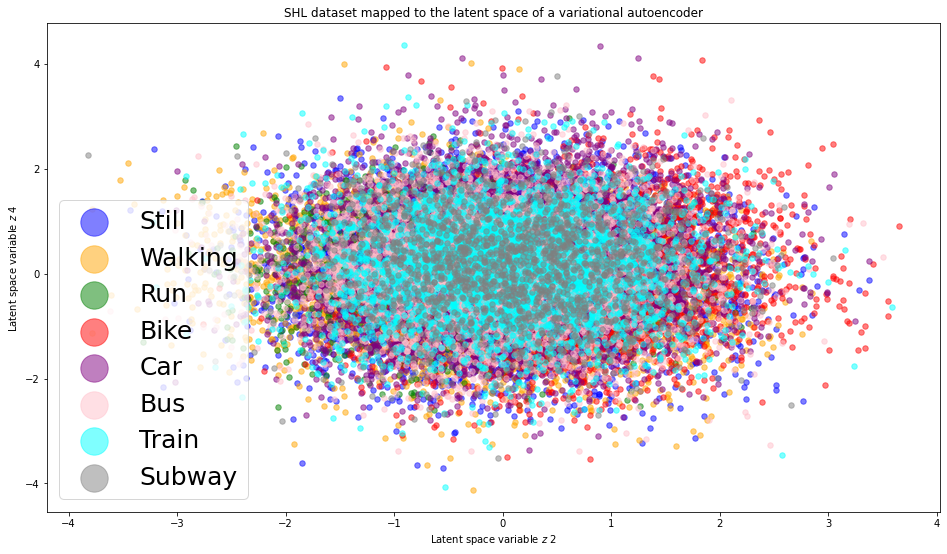

In [136]:
# Define latent variable to plot:
lat_var_1 = 2
lat_var_2 = 4

# Calculate mean and variance: 
mu, var  = eval_VAE.calc_mu_var(device,VAE_1,x_sample)

eval_VAE.plot_hist(mu, var, lat_var_1)
eval_VAE.plot_hist(mu, var, lat_var_2)
eval_VAE.plot_latent(x_test,y_test,VAE_1,lat_var_1,lat_var_2,n_plot = 30000)

#**Caclulate points with postivie potential:**

Find points with positive potential:

In [51]:
#Hyperparameters:
w      = 0.999 # Neighbour distance
gamma  = 0.05  # Hyperparameter for potential 

# Define train, test and evalloader:
trainloader_no_shuffle = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = False)

# Map data to latent space: 
# IMPORTANT: Dataloader should not be shuffled! Otherwise Z_train and Y_train do not match
Z_train = potential.map_dataloader_to_latent(trainloader_no_shuffle,VAE_1,device)

KeyboardInterrupt: ignored

Define distance metric:

In [ ]:
cos = nn.CosineSimilarity(dim = 1)

Calculate for each point its potential

In [ ]:
# Calculate for every point its potential
potential_ = potential.main_potential(Z_train,y_train,w,gamma,cos,device)

Progress: 0/337617
Progress: 10000/337617
Progress: 20000/337617
Progress: 30000/337617
Progress: 40000/337617
Progress: 50000/337617
Progress: 60000/337617
Progress: 70000/337617
Progress: 80000/337617
Progress: 90000/337617
Progress: 100000/337617
Progress: 110000/337617
Progress: 120000/337617
Progress: 130000/337617
Progress: 140000/337617
Progress: 150000/337617
Progress: 160000/337617
Progress: 170000/337617
Progress: 180000/337617
Progress: 190000/337617
Progress: 200000/337617
Progress: 210000/337617
Progress: 220000/337617
Progress: 230000/337617
Progress: 240000/337617
Progress: 250000/337617
Progress: 260000/337617
Progress: 270000/337617
Progress: 280000/337617
Progress: 290000/337617
Progress: 300000/337617
Progress: 310000/337617
Progress: 320000/337617
Progress: 330000/337617


Extract points with postive potential:

In [ ]:
X_pot, Y_pot, Z_pot, X_no_pot, Y_no_pot, Z_no_pot = potential.split_potential(x_train,y_train,Z_train,potential_)

Generate dataloader containing X_pot, X_no_pot and both combined.

In [ ]:
trainloader_pot        = lpd.generate_dataloader(X_pot,Y_pot, batch_size, shuffle = False)
trainloader_no_pot     = lpd.generate_dataloader(X_no_pot,Y_no_pot, batch_size, shuffle = False)
trainloader_no_shuffle = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = False)

Print stats about positive potential dataset:

In [ ]:
df  = eval_potential.stats_pot_dataset(Y_pot, Y_no_pot, y_train)
df 

,N X_pot,N X_no_pot,N X_train,Frac X_pot [%],Frac X_no_pot [%],Frac X_train [%]
Still,516,47093,47609,3.7,14.6,14.1
Walking,428,44861,45289,3.1,13.9,13.4
Run,4,14219,14223,0.0,4.4,4.2
Bike,469,42933,43402,3.3,13.3,12.9
Car,2274,48888,51162,16.2,15.1,15.2
Bus,1100,42135,43235,7.8,13.0,12.8
Train,4998,47171,52169,35.6,14.6,15.5
Subway,4242,36286,40528,30.2,11.2,12.0
Sum,14031,323586,337617,100.0,100.0,100.0


Plot points with positive potential:

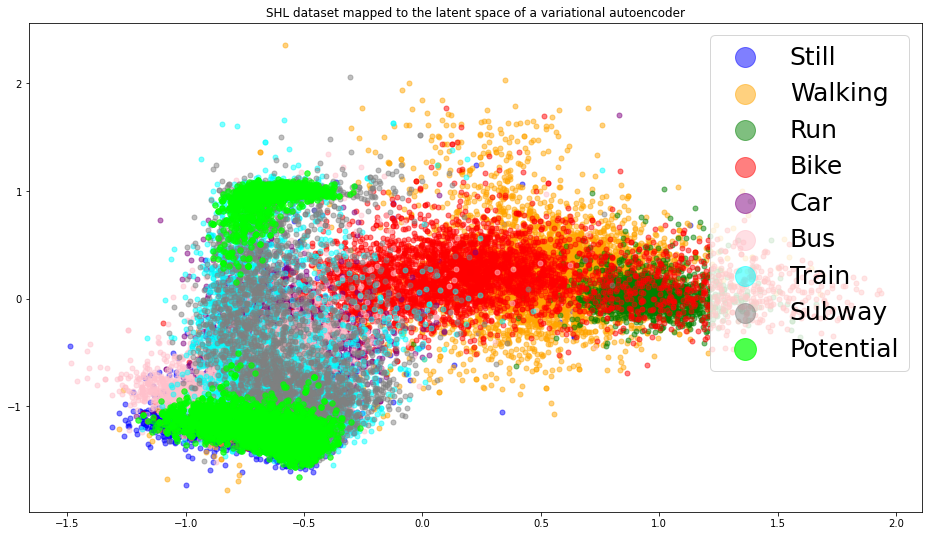

In [ ]:
potential.plot_latent_space_with_pot(Y_pot, Z_pot,Y_no_pot, Z_no_pot,N_pot = 5000, N_no_pot = 30000 ,lat_var_1 = 0,lat_var_2 = 1)

**Generate retrain dataset accroding to: z = mu + beta epsilon var**


In [ ]:
X_pot_retrain, Y_pot_retrain = retrain_FC.generate_retrainset(X_pot,Y_pot,VAE_1,device)
trainloader_pot_rec_retrain  = lpd.generate_dataloader(X_pot,Y_pot, batch_size, shuffle = False)

**Evaluate dataset of points with positive potential:**
1. How does points with positive potential perform compared to points with negative potential on the baseline classifier and compared to overall dataset.
2. What is the reconstruction error of points with positive potential.

In [ ]:
torch.cuda.empty_cache()

First the performance of the baseline classifier on traindata, traindata with positive potential and traindata with negative potential is evaluated. The performance of traindata with positive potential should not be too low, otherwise retraining on that dataset probably will lead to bad performance.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot, trainloader_no_pot, trainloader_no_shuffle,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on traindata, traindata with postivie potential and traindata with negeative potential')

,Train,Pot,No Pot
Loss,1.445785,2.084596,1.442735
Accuracy,0.830219,0.551504,0.833404
F1 Score,0.828591,0.461546,0.831900


Next, traindata, traindata with postitive potential and traindata with negative potential are fed through the VAE to generate their reconstructed signal. The performance of VAE on those three datasets is evaluated.

In [ ]:
X_pot_rec    = potential.map_dataloader_to_rec(trainloader_pot,VAE_1,device)
X_no_pot_rec = potential.map_dataloader_to_rec(trainloader_no_pot,VAE_1,device)
X_train_rec  = potential.map_dataloader_to_rec(trainloader_no_shuffle,VAE_1,device)

trainloader_pot_rec    = lpd.generate_dataloader(X_pot_rec,Y_pot, batch_size, shuffle = False)
trainloader_no_pot_rec = lpd.generate_dataloader(X_no_pot_rec,Y_no_pot, batch_size, shuffle = False)
trainloader_rec        = lpd.generate_dataloader(X_train_rec,y_train, batch_size, shuffle = False)

del X_pot_rec, X_no_pot_rec, X_train_rec

In [ ]:
df = eval_potential.evaluate_dataset_on_vae(trainloader_pot, trainloader_no_pot, trainloader,device,beta, VAE_1)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of VAE on traindata, traindata with postivie potential and traindata with negeative potential')

,Train,Pot,No Pot
Loss,4590.618960,972.901693,4623.682727
Rec Loss,0.012167,0.002551,0.012255
KL Loss,38.335006,49.190880,38.300841


Last, the performance of the classifier on the reconstructed traindataset, reconstructed traindataset with postitive potential and reconstructed traindata with negative potential is evaluated. The accuracy using the reconstructed dataset with positive potential should not be too low, since it will be used for retraining the classifier.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot_rec, trainloader_no_pot_rec, trainloader_rec,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on reconstructed traindata, reconstructed traindata with postivie potential and reconstructed traindata with negeative potential')
df 

,Train,Pot,No Pot
Loss,1.524635,2.095927,1.522195
Accuracy,0.748970,0.541837,0.751486
F1 Score,0.740640,0.376727,0.743273


Also evaluate the performance of the dataloader trainloader_pot_rec_retrain, containing multiple reconstructions of each point with postive potential.

In [ ]:
df = eval_potential.evaluate_dataset_on_classifier(trainloader_pot_rec_retrain, trainloader_no_pot_rec, trainloader_rec,fc_base,device,criterion)
df.style.set_table_attributes("style='display:inline'").set_caption('Performance of classifier on reconstructed traindata, reconstructed traindata with postivie potential and reconstructed traindata with negeative potential')
df

,Train,Pot,No Pot
Loss,1.524635,2.084596,1.522195
Accuracy,0.748970,0.551504,0.751486
F1 Score,0.740640,0.461546,0.743273


#**Retrain base classifier:**

Initialize classifier to retrain. All layers will be retrained.

In [ ]:
# Hyperparamter of retrain classifier:
dir_folder_fc_base = '/content/drive/MyDrive/Colab_Notebooks/Experiments/Results/FC/Classifier/' # Directory of baseline classifier
dir_fc_base        = dir_folder_fc_base + 'best_model.pth' 
device             = 'cuda' # Device where calculations are performed
fc_retrain_1 = 0.25

# Initialize retrain classifier with desired weights
fc_retrain_1  = FC.FC(dropout_fc = fc_retrain_1).to(device)
fc_retrain_1  = basic_functions.initialize_model(fc_retrain_1,dir_fc_base)

Start retraining classifier:

Epoch [0], train_loss: 2.0846,train_acc: 0.5515,train_f1: 0.4615,test_loss: 1.4968, test_acc: 0.7928, test_f1:0.7901

Best validation loss: 0.7927990191999603

Saving best model for epoch: 1


Best validation loss: 0.7977549065561855

Saving best model for epoch: 1

Epoch [1], train_loss: 2.0557,train_acc: 0.5741,train_f1: 0.5539,test_loss: 1.4919, test_acc: 0.7978, test_f1:0.7959

Best validation loss: 0.7986225507715169

Saving best model for epoch: 1

Epoch [2], train_loss: 2.0416,train_acc: 0.6003,train_f1: 0.4855,test_loss: 1.4907, test_acc: 0.7986, test_f1:0.7954
Epoch [3], train_loss: 2.0417,train_acc: 0.6047,train_f1: 0.4742,test_loss: 1.4929, test_acc: 0.7963, test_f1:0.7928
Epoch [4], train_loss: 2.0322,train_acc: 0.6076,train_f1: 0.5079,test_loss: 1.4970, test_acc: 0.7925, test_f1:0.7904
Epoch [5], train_loss: 2.0269,train_acc: 0.6237,train_f1: 0.5814,test_loss: 1.5027, test_acc: 0.7868, test_f1:0.7860


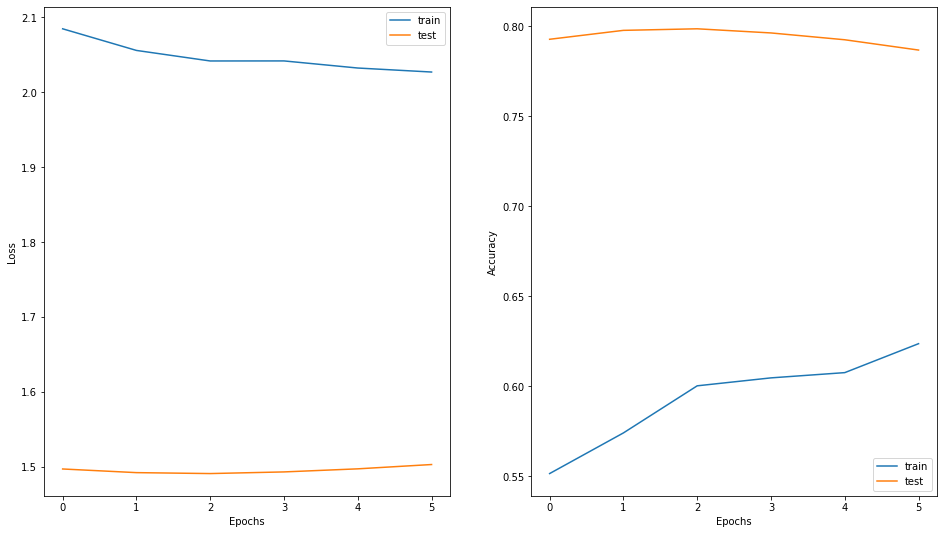

In [ ]:
# Define train state cnn
train_state_1    = 1 # 1 := train cnn, 0 := dont train cnn
epochs           = 5
dir_store_folder = '/content/drive/MyDrive/Colab_Notebooks/Experiments/Results/IHDA/FC_'+str(layer)+'/Classifier'

# Initialize optimizer:
optimizer  = optim.Adam(fc_retrain_1.parameters(), lr =  0.00001,betas=(0.9, 0.999)) #cnn_retrain.parameters()


# Dataloader for training:
dataloader_training = trainloader_pot_rec_retrain


if train_state_1 == 1:
  retrain_FC.main_retrain_classifier(dataloader_training,testloader,fc_retrain_1,device, criterion,optimizer,epochs,dir_store_folder)


Evaluate retrained classifier